# Extract topics  of  NSF OCE awards
Created by Ivan Lima on 2020-03-28 10:25:36 

In this notebook we:

- Apply lemmatization to award abstracts.
- Extract research topics from NSF-OCE award abstracts using non-negative matrix factorization (NMF).
- Estimate award interdisciplinarity based on the evenness of the distribution of topic probabilities.
- Compute t-SNE embedding vectors for awards based on the extracted topic probabilities.
- Set award types

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime, re
import matplotlib.pyplot as plt
from tqdm import tnrange, notebook

In [2]:
pd.options.display.max_columns = 30
plt.rcParams['figure.dpi'] = 100
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Tue Mar  9 22:44:40 2021


## Read NSF-OCE data

In [3]:
data_types = {'Abstract':'string', 'Title':'string', 'Programs':'string', 'PI':'string',
              'Organization':'string', 'State':'string', 'Instrument':'string', 'co-PIs':'string',
              'program':'string', 'PI_first_name':'string', 'co-PI_first_name':'string',
              'PI_gender':'string', 'co-PI_gender':'string'}
awards = pd.read_csv('data/awards_1985-2020_clean_edited_grouped_gender.csv', index_col=0,
                     parse_dates=[4,5], dtype=data_types)
awards.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11513 entries, 8911427 to 844394
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Abstract             11513 non-null  string        
 1   Title                11513 non-null  string        
 2   Programs             11491 non-null  string        
 3   StartDate            11513 non-null  datetime64[ns]
 4   EndDate              11513 non-null  datetime64[ns]
 5   PI                   11481 non-null  string        
 6   Organization         11513 non-null  string        
 7   State                11364 non-null  string        
 8   Instrument           11513 non-null  string        
 9   n_awards             11513 non-null  int64         
 10  co-PIs               5784 non-null   string        
 11  num_co-PIs           5784 non-null   float64       
 12  total_amount         11513 non-null  float64       
 13  total_ARRA           115

## Apply lemmatization to abstracts

In [4]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
# nltk.download('punkt') # download only once
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def get_pos_tag(s):
    """ Map POS tag to first character lemmatize() accepts """
    tag = s[0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def custom_tokenizer(doc):
    return [lemmatizer.lemmatize(w, get_pos_tag(s)) for w, s in nltk.pos_tag(nltk.word_tokenize(doc))]

abstracts = [' '.join(custom_tokenizer(s)) for s in awards.Abstract]

## Convert list of abstracts to bag-of-words matrix using tf-idf scaling

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

stopwords = ENGLISH_STOP_WORDS.union(set(['nsf', 'program', 'proposal', 'award', 'merit', 'criterion',
                                          'impact', 'model', 'support', 'new', 'time', 'water',
                                          'marine', 'year', 'day', 'pi', 'pis', 'intellectual',
                                          'funded', 'fund']))

# vectorizer_tf = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.4).fit(abstracts)
vectorizer_tfidf = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.4).fit(abstracts)

# X_tf = vectorizer_tf.transform(abstracts)
X_tfidf = vectorizer_tfidf.transform(abstracts)

print('X_tfidf shape:{}'.format(X_tfidf.shape))

X_tfidf shape:(11513, 10562)


**Most frequent & least frequent words in abstracts:**

In [6]:
tot_freq = X_tfidf.toarray().sum(axis=0)
sort_by_freq = np.argsort(tot_freq)
feature_names = np.array(vectorizer_tfidf.get_feature_names())
print('Words with high tf-idf (increasing order):\n{}'.format(feature_names[sort_by_freq[-200:]]))
# print('\nWords with low tf-idf (increasing order):\n{}'.format(feature_names[sort_by_freq[:100]]))

Words with high tf-idf (increasing order):
['small' 'identify' 'addition' 'atmospheric' 'upper' 'past' 'world'
 'tracer' 'acquisition' 'growth' 'mixing' 'plan' 'available' 'margin'
 'crust' 'general' 'vent' 'co2' 'seawater' 'influence' 'wind' 'heat'
 'design' 'gulf' 'set' 'concentration' 'experience' 'analyze' 'primary'
 'continue' 'satellite' 'approach' 'exist' 'range' 'numerical' 'specific'
 'international' 'present' 'workshop' 'near' 'estimate' 'event'
 'objective' 'particle' 'hypothesis' 'trace' 'mechanism' 'group' 'mass'
 'improve' 'layer' 'variation' 'increase' 'investigate' 'involve' 'term'
 'resolution' 'microbial' 'mid' 'information' 'component' 'potential'
 'base' 'broad' 'capability' 'address' 'low' 'composition' 'method'
 'nitrogen' 'sensor' 'boundary' 'response' 'basin' 'oxygen' 'seafloor'
 'future' 'effort' 'series' 'different' 'phytoplankton' 'interaction'
 'environmental' 'goal' 'reef' 'observation' 'shelf' 'oceanography'
 'mantle' 'depth' 'cycle' 'element' 'request' 't

In [7]:
# feature_names[:100]
# feature_names[-100:]
# vectorizer.vocabulary_
# vectorizer.stop_words_

## Extract topics using NMF

In [8]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.preprocessing import normalize

n_topics = 21 # number of topics to extract

# lda = LatentDirichletAllocation(n_components=n_topics, learning_method='batch', max_iter=25,
#                                 n_jobs=-1, random_state=42)
## lda = LatentDirichletAllocation(n_components=n_topics, learning_method='batch', max_iter=25,
##                                 n_jobs=-1, random_state=44)
# X_topics = lda.fit_transform(X)

nmf = NMF(n_components=n_topics,random_state=42,init='nndsvd',max_iter=500)
X_topics = nmf.fit_transform(X_tfidf)
# normalize NMF weights to unit length (topic probabilities)
X_topics = normalize(X_topics, norm='l1') 

awards['topic'] = np.argmax(X_topics,axis=1) + 1
awards['topic_prob'] = X_topics.max(axis=1)

**Top 10 words in each topic:**

In [9]:
sort_by_feature = np.argsort(nmf.components_, axis=1)[:,::-1]
topic_names_r = np.array(['{:2d} {}'.format(n+1, ' '.join(s))
                        for n, s in enumerate(feature_names[sort_by_feature[:,:10]])])
topic_freq = X_topics.sum(axis=0)/X_topics.sum()

for tn, tf in zip(topic_names_r, topic_freq):
    print('{:107s} {:4.1f}%'.format(tn, tf*100))

 1 shelf coastal transport river process current wind plume physical estuary                                 3.2%
 2 equipment scientific shipboard transceivers retrieval communication satellite winch radar site            3.2%
 3 instrumentation university shared oceanographic vessel request researcher fleet acquisition operate       4.9%
 4 ridge mantle melt mid magma crust spreading rock crustal basalt                                           5.0%
 5 wave internal turbulence mixing energy layer surface turbulent dissipation wind                           5.8%
 6 population larval specie fish larva zooplankton predator recruitment prey copepod                         5.2%
 7 coral reef bleaching disease caribbean bleach community ecosystem host stress                             2.4%
 8 workshop science international scientific activity community scientist office committee national          6.8%
 9 carbon organic co2 flux matter doc cycle production dioxide global                   

**Top 20 words in each topic:**

In [10]:
n_top_words = 20 # number of words to show per topic
sort_by_feature = np.argsort(nmf.components_, axis=1)[:,::-1]
cols = ['topic {}'.format(n+1) for n in range(nmf.components_.shape[0])]
df_topics = pd.DataFrame(feature_names[sort_by_feature][:,:n_top_words].transpose(),columns=cols)
df_topics

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,topic 11,topic 12,topic 13,topic 14,topic 15,topic 16,topic 17,topic 18,topic 19,topic 20,topic 21
0,shelf,equipment,instrumentation,ridge,wave,population,coral,workshop,carbon,sediment,hydrothermal,sensor,circulation,trace,iron,vessel,student,microbial,seismic,nitrogen,climate
1,coastal,scientific,university,mantle,internal,larval,reef,science,organic,core,vent,instrument,woce,element,fe,ship,reu,phytoplankton,earthquake,fixation,change
2,transport,shipboard,shared,melt,turbulence,specie,bleaching,international,co2,organic,fluid,measurement,atlantic,isotope,phytoplankton,operate,science,cell,plate,n2,record
3,river,transceivers,oceanographic,mid,mixing,fish,disease,scientific,flux,margin,flow,capability,current,geotraces,diatom,oceanographic,experience,bacteria,subduction,nitrate,variability
4,process,retrieval,vessel,magma,energy,larva,caribbean,activity,matter,trap,temperature,acoustic,hydrographic,sample,metal,operation,undergraduate,community,fault,production,sea
5,current,communication,request,crust,layer,zooplankton,bleach,community,doc,sample,ridge,development,north,metal,ligand,schedule,summer,virus,zone,oxygen,ice
6,wind,satellite,researcher,spreading,surface,predator,community,scientist,cycle,benthic,chemical,instrumentation,pacific,distribution,nutrient,university,students,gene,margin,denitrification,temperature
7,plume,winch,fleet,rock,turbulent,recruitment,ecosystem,office,production,sedimentary,heat,develop,experiment,particle,production,cruise,career,diversity,slip,nutrient,glacial
8,physical,radar,acquisition,crustal,dissipation,prey,host,committee,dioxide,flux,seafloor,seafloor,deep,arctic,productivity,general,graduate,molecular,cascadia,trichodesmium,core
9,estuary,site,operate,basalt,wind,copepod,stress,national,global,matter,mineral,measure,world,tracer,seawater,require,week,bacterial,deformation,rate,past


In [11]:
df_topics[['topic 3','topic 12','topic 2','topic 16']]

,topic 3,topic 12,topic 2,topic 16
0,instrumentation,sensor,equipment,vessel
1,university,instrument,scientific,ship
2,shared,measurement,shipboard,operate
3,oceanographic,capability,transceivers,oceanographic
4,vessel,acoustic,retrieval,operation
5,request,development,communication,schedule
6,researcher,instrumentation,satellite,university
7,fleet,develop,winch,cruise
8,acquisition,seafloor,radar,general
9,operate,measure,site,require


In [12]:
def top_abstracts(xtopic, topic_number, n_abstracts=5, n_sentences=10):
    """ Show first n_sentences of top n_abstracts for given topic number """
    sort_abstracts = np.argsort(xtopic[:,topic_number-1])[::-1] # descending order
    print('Topic {}:'.format(topic_number))
    for n in sort_abstracts[:n_abstracts]:
        print('\n{} ...'.format('. '.join(abstracts[n].split('.')[:n_sentences])))

# top_abstracts(X_topics, 16, 10)

### Relative frequency of awards per topic (topic weights)

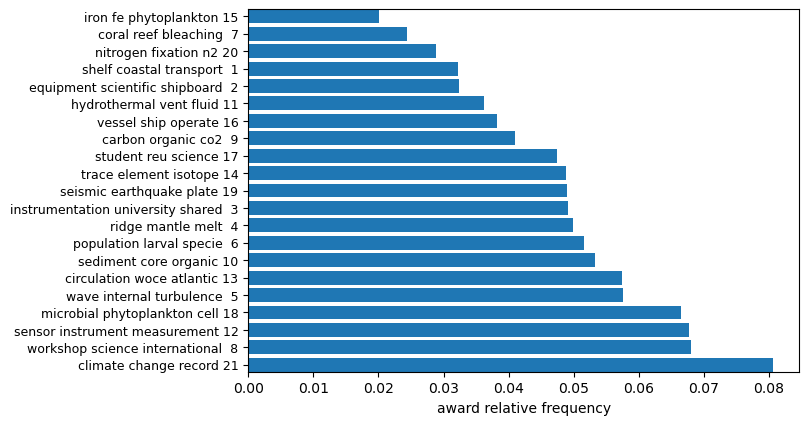

In [13]:
topic_names = np.array(['{} {:2d}'.format(' '.join(s), n+1)
                        for n, s in enumerate(feature_names[sort_by_feature[:,:3]])])
topic_names_r = np.array(['{:2d} {}'.format(n+1, ' '.join(s))
                        for n, s in enumerate(feature_names[sort_by_feature[:,:3]])])

topic_freq = X_topics.sum(axis=0)/X_topics.sum()
sort_by_freq = np.argsort(topic_freq)[::-1]

fig, ax = plt.subplots(figsize=(9.5,4.8))
fig.subplots_adjust(left=0.32)
_ = ax.barh(range(n_topics), topic_freq[sort_by_freq])
_ = ax.set_yticks(range(n_topics))
_ = ax.set_yticklabels(topic_names[sort_by_freq],fontsize=9)
_ = ax.set(xlabel='award relative frequency')
ax.autoscale(axis='y',tight=True)

### Relative frequency of words per topic (topic loads)

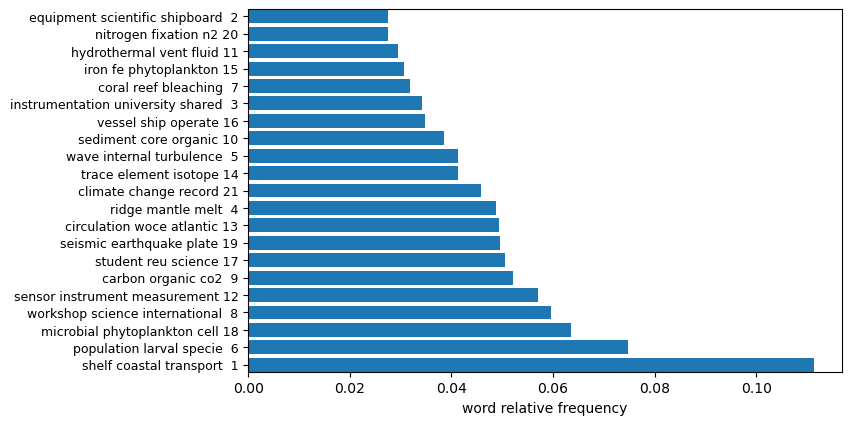

In [14]:
topic_load = nmf.components_.sum(axis=1)/nmf.components_.sum()
sort_by_load = np.argsort(topic_load)[::-1]

fig, ax = plt.subplots(figsize=(9.5,4.8))
fig.subplots_adjust(left=0.275)
fig.subplots_adjust(left=0.275)
_ = ax.barh(range(n_topics), topic_load[sort_by_load])
_ = ax.set_yticks(range(n_topics))
_ = ax.set_yticklabels(topic_names[sort_by_load],fontsize=9)
_ = ax.set(xlabel='word relative frequency')
ax.autoscale(axis='y',tight=True)

## Estimate award interdisciplinarity using Pielou's evenness/diversity index 

In [15]:
probs = np.copy(X_topics)
probs[probs==0] = 1.e-6 # avoid log(0)

p = np.repeat(np.array(1/n_topics),n_topics)
Hmax = (-p * np.log(p)).sum()
H = (-probs * np.log(probs)).sum(axis=1)
awards['evenness'] = H/Hmax

## Compute t-SNE embedding vectors

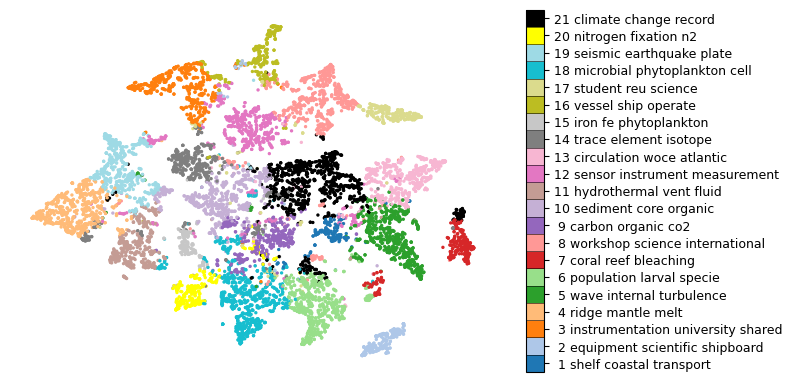

In [16]:
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

tsne = TSNE(random_state=42)
X_tsne = tsne.fit_transform(X_topics)

tab20 = plt.cm.get_cmap('tab20')
newcolors = tab20.colors + ((1,1,0.0),) + ((0,0,0),)
tab22 = ListedColormap(newcolors,'tab22')

fig, ax = plt.subplots(figsize=(9,4.8))
fig.subplots_adjust(right=0.8)
sp = ax.scatter(X_tsne[:,0], X_tsne[:,1], s=2, c=awards.topic.values-1, cmap=tab22, alpha=1)
ax.axis('off')
cb = fig.colorbar(sp,ax=ax,values=range(n_topics),boundaries=range(n_topics+1),
                  ticks=np.arange(0.5,n_topics+0.5),drawedges=True)
cb.set_ticklabels(topic_names_r)
cb.ax.tick_params(labelsize=9)

## Set award types

Types of awards and initiatives identified in the data include:

- Collaborative Research
- EAGER: EArly-concept Grant For Exploratory Research
- RAPID: Rapid Response Research
- REU: Research Experience for Undergraduates
- RUI: Research in Undergraduate Institutions
- SGER: Small Grants for Exploratory Research
- CAREER: Faculty Early Career Development
- CMG: Collaboration in Mathematical Geosciences
- POWRE: Professional Opportunities for Women in Research and Education

SGER is an older type of award (~2003) that seems to be a combination of EAGER and RAPID, but more like EAGER. Therefore we are grouping these two types of awards together as EAGER awards.

In [17]:
# awards = awards.drop('award_type', axis=1)
awards.loc[awards.Title.str.contains('collaborative\s'),'award_type'] = 'Collaborative Research'
awards.loc[awards.Title.str.contains('eager\s'),'award_type'] = 'EAGER'
awards.loc[awards.Title.str.contains('rapid\s'),'award_type'] = 'RAPID'
awards.loc[awards.Title.str.contains('sger\s'),'award_type'] = 'EAGER'
awards.loc[awards.Title.str.contains('reu\s'),'award_type'] = 'REU'
awards.loc[awards.Title.str.contains('rui\s'),'award_type'] = 'RUI'
awards.loc[awards.Title.str.contains('career\s'),'award_type'] = 'CAREER'
awards.loc[awards.Title.str.contains('cmg\s'),'award_type'] = 'CMG'
awards.loc[awards.Title.str.contains('powre\s'),'award_type'] = 'POWRE'
awards['award_type'] = awards.award_type.fillna('standard')

## Save results to file

In [18]:
# award data with topic and associated topic probability
awards.to_csv('results/awards_1985-2020_clean_edited_grouped_gender_topic.csv')

# distribution of topic probabilities for each award
topic_probs = pd.DataFrame(X_topics, index=awards.index, columns=df_topics.columns)
topic_probs.to_csv('results/topic_probs.csv')

# 20 most frequent words for each topic
df_topics.to_csv('results/topic_words.csv')

# bag-of-words features, NMF components, topic names & t-SNE embedding vectors
np.savez_compressed('results/NMF_TSNE',
                    feature_names=feature_names,
                    nmf_components=nmf.components_,
                    topic_names=topic_names,
                    topic_names_r=topic_names_r,
                    X_tsne=X_tsne)